# Precompute exposure integral

In order to add in the 2D Aeff, want to precompute the factor:

$$
\epsilon_k = T \frac{(\alpha-1)}{E_{\rm{min}}} \int_{E_{\rm{min}}}^\infty {\rm{d}}E \ A_{\rm{eff}}(E, \varpi_k) 
\Bigg( \frac{(1+z_k)E}{E_{\rm{min}}} \Bigg)^{-\alpha}, 
$$
for each source, indexed by $k$. This factor has units of $m^2 \ yr$, and we consider energy in GeV.

In [1]:
import numpy as np
import h5py
from scipy.interpolate import RectBivariateSpline

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

/Users/fran/projects/bayes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Effective area

Use what you have from the `spline_dev/` examples!

In [2]:
# First, get the effective area
with h5py.File('../data/Aeff_shape.h5', 'r') as f:
    log10E = f['log10E'].value
    cosz = f['cosz'].value
    log10Aeff = f['log10Aeff'].value

In [3]:
# Spline
spline = RectBivariateSpline(log10E, cosz, log10Aeff)

output = np.zeros((100,100))

#log10E = np.linspace(3, 10, 100)
for i, E in enumerate(log10E):
    for j, c in enumerate(cosz):
        output[i][j] = spline(E, c)

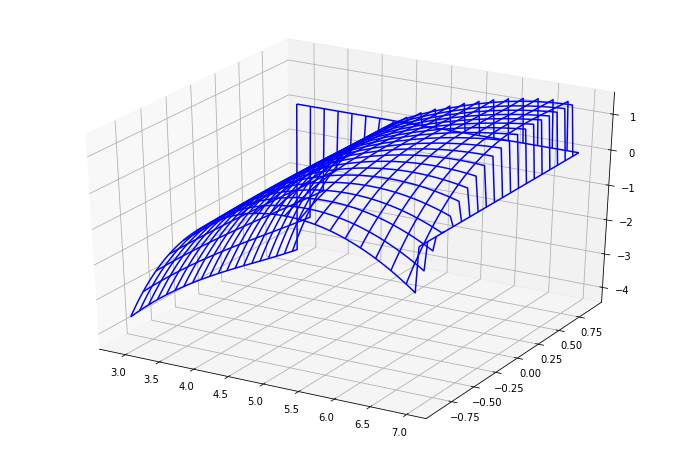

In [4]:
xx, yy = np.meshgrid(log10E, cosz)
xx=xx.T
yy=yy.T

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_wireframe(xx, yy, output, rstride=5, cstride=5, color='blue')

## Sources

We can only precompute for a predefined set of redshifts and sky positions. Copy over what you do in the main code for now.

In [5]:
# Use a set of sources uniform in comoving volume for a lambda-CDM universe.
with h5py.File('../data/test_SFR_pop.h5', 'r') as f:
    Ns = f['output/Ns'].value
    redshift = f['output/redshift'].value
    position = f['output/position'].value
    
# Select sources within redshift zth to mimic catalogue
zth = 1
selection = np.where(redshift < zth)[0]

In [6]:
Ns = len(selection)
redshift = np.array([redshift[_] for _ in selection])
position = np.array([position[_] for _ in selection])

# Try ordering sources by redshift, as larger z => lower F
# This could help eliminate degeneracies in the mixture
inds = redshift.argsort()[::-1]
redshift = redshift[inds]
position = position[inds]
unit_vector = [p / np.linalg.norm(p) for p in position]

# Add background redshift
source_redshift = list(redshift) 
bg_redshift = zth

## Computation

For all the sources in the sample, produce a 1d grid to interpolate over

In [10]:
from scipy import integrate

In [43]:
Emax = 1e7 # GeV (max of spline)

def omega_to_cosz(omega):
    return np.cos(np.pi - np.arccos(omega[2]))

def integrand(E, spline, varpi, z, Emin, alpha):
    log10E = np.log10(E) # log10GeV
    cosz = omega_to_cosz(varpi)
    Aeff = 10**(spline(log10E, cosz)) # m^2
    return Aeff * ( ((1+z)*E) / Emin )**(-alpha)

def integrand_bg(E, theta, spline, z, Emin, alpha):
    log10E = np.log10(E) # log10GeV
    cosz = np.cos(np.pi - theta)
    Aeff = 10**(spline(log10E, cosz)) # m^2
    return Aeff * ( ((1+z)*E) / Emin )**(-alpha) * np.sin(theta) 

def integrand_bg_old(E, cosz, spline, z, Emin, alpha):
    log10E = np.log10(E) # log10GeV
    Aeff = 10**(spline(log10E, cosz)) # m^2
    return Aeff * ( ((1+z)*E) / Emin )**(-alpha)

def get_eps(spline, varpi, z, Emin, alpha):
    integ, err = integrate.quad(integrand, Emin, Emax, # debug! 
                                args=(spline, varpi, z, Emin, alpha))
    if (err > 1e2):
        print('ah shit')
    return integ

def get_eps_bg(spline, z, Emin, alpha):
    integ, err = integrate.dblquad(integrand_bg, 0, np.pi, 
                                   lambda x : Emin, lambda x : Emax, 
                                   args=(spline, z, Emin, alpha))
    print(integ, err)
    if (err > 1e2):
        print('ah shit')
    return integ

def get_eps_bg_old(spline, z, Emin, alpha):
    integ, err = integrate.dblquad(integrand_bg_old, -1, 1, 
                                   lambda x : Emin, lambda x : Emax, 
                                   args=(spline, z, Emin, alpha))
    print(integ, err)
    if (err > 1e2):
        print('ah shit')
    return integ

In [44]:
# Set up params
Emin = 1e4 # GeV, ie. 10 TeV
alpha = np.logspace(np.log(1.5), np.log(4), 50, base=np.e)

### Testing out improvements

In [ ]:
# Pick out the tricky parts
test_z = source_redshift[0]
eps_k = []
for a in alpha:
    eps_k.append(get_eps(spline, varpi, z, Emin, a))

In [ ]:
fig, ax = plt.subplots()
ax.scatter(alpha, eps[0], label='inf')
ax.scatter(alpha, eps_k, label='1e5*Emin')

ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')

### Background

In [18]:
z_bg = bg_redshift
alpha = [1.6]
eps_bg = []
eps_bg_old = []
for a in alpha:
    eps_bg.append(get_eps_bg(spline, z_bg, Emin, a))    
    eps_bg_old.append(get_eps_bg_old(spline, z_bg, Emin, a))

166423.52525109935 0.0016300066880144551
166423.5251676433 0.0017826812553755423


In [19]:
print('new:', eps_bg[0])
print('old:', eps_bg_old[0])

new: 166423.52525109935
old: 166423.5251676433


In [20]:
# Testing Aeff integral in different coords

def Aeff_integrand_1(cosz, E, spline, Emin, alpha):    
    Efac = ( ((1+1)*E) / Emin )**(-alpha)
    return 10**(spline(np.log10(E), cosz)) * 2*np.pi * Efac

def Aeff_integrand_2(theta, E, spline, Emin, alpha):
    Efac = ( ((1+1)*E) / Emin )**(-alpha)
    return ( 10**(spline(np.log10(E), np.cos(np.pi-theta))) 
            * np.sin(theta) * 2 * np.pi * Efac)

In [21]:
# Fixing E
fixed_E = 1e4 # GeV
alpha = 1.6
integ, err = integrate.quad(Aeff_integrand_1, -1, 1, 
                            args=(fixed_E, spline, Emin, alpha))
print(integ, err)
integ, err = integrate.quad(Aeff_integrand_2, 0, np.pi, 
                            args=(fixed_E, spline, Emin, alpha))
print(integ, err)

1.278544736078228 7.061447426792711e-09
1.2785447368310365 3.527356851051877e-09


In [22]:
# Integrating over E
alpha = 1.6
integ, err = integrate.dblquad(Aeff_integrand_1, Emin, Emax, 
                               lambda x : -1, lambda x : 1, 
                               args=(spline, Emin, alpha))
print(integ, err)
integ, err = integrate.dblquad(Aeff_integrand_2, Emin, Emax, 
                               lambda x : 0, lambda x : np.pi, 
                               args=(spline, Emin, alpha))
print(integ, err)

166423.61286186983 0.0011641671881079674
166423.5257946954 0.001062248949892819


### The real deal

In [45]:
# Sources
eps = []
for varpi, z in zip(unit_vector, source_redshift):
    eps_k = []
    for a in alpha:
        eps_k.append(get_eps(spline, varpi, z, Emin, a))
    eps.append(eps_k)
# Background
eps_k = []
for a in alpha:
    eps_k.append(get_eps_bg(spline, bg_redshift, Emin, a))
eps.append(eps_k)

39657.202154646126 0.00043650512978032576
34978.95640330449 0.0003725284447453626
30860.734066323635 0.0003171432645991026
27237.54261918733 0.000269218675665649
24051.298030710666 0.00022800227552821853
21250.20996395546 0.0001923318458128417
18788.203018667085 0.0001767992781377176
16624.374568956984 0.00024243139006522235
14722.489334592132 0.00019438399734668653
13050.510419610266 0.00015312463666312498
11580.16613779564 0.00011810207999489173
10286.551702082905 9.469884023803675e-05
9147.764503424229 0.00010804213238544335
8144.571745174094 7.233428494295786e-05
7260.108354184738 6.395566258736747e-05
6479.604089599685 6.461378450013395e-05
5790.137556814602 7.691085941030412e-05
5180.415391196248 6.810160125512305e-05
4640.574921091499 5.9155902454594044e-05
4162.008116644739 5.157819475111111e-05
3737.20536772455 4.709823755333379e-05
3359.617079698172 3.8065088712574066e-05
3023.5314559659637 3.075724610259412e-05
2723.9669740270533 2.4847748402244536e-05
2456.577935974106 2.00

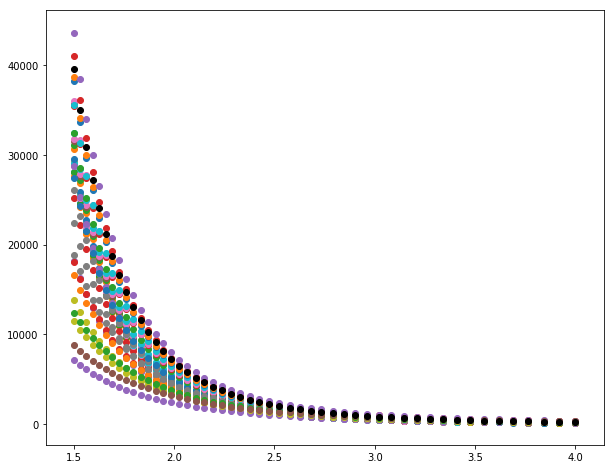

In [46]:
fig, ax = plt.subplots()
fig.set_size_inches((10,8))
for eps_k in eps[0:-2]:
    ax.scatter(alpha, np.array(eps_k))
ax.scatter(alpha, np.array(eps[-1]), color='k')
#ax.set_yscale('log')
#ax.set_xscale('log')

In [47]:
with h5py.File('precomputed_eps_fixbg.h5', 'w') as f:
    f.create_dataset('alpha_grid', data=alpha)
    f.create_dataset('eps', data=eps)
    f.create_dataset('varpi', data=unit_vector)
    f.create_dataset('redshift', data=source_redshift + [bg_redshift])
    f.create_dataset('Emin', data=Emin)

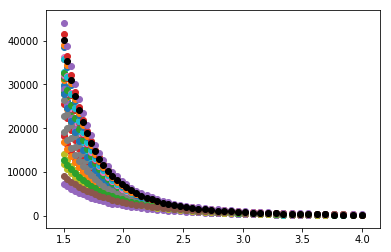

In [41]:
# Compare with old results
with h5py.File('precomputed_eps_test.h5', 'r') as f:
    eps = f['eps'].value
    alpha = f['alpha_grid'].value
    
fig, ax = plt.subplots()
for eps_k in eps[0:-2]:
    ax.scatter(alpha, eps_k)
ax.scatter(alpha, eps[-1], color='k')